# Reducing hospital readmissions

## 📖 Background
You work for a consulting company helping a hospital group better understand patient readmissions. The hospital gave you access to ten years of information on patients readmitted to the hospital after being discharged. The doctors want you to assess if initial diagnoses, number of procedures, or other variables could help them better understand the probability of readmission. 

They want to focus follow-up calls and attention on those patients with a higher probability of readmission.

## 💪 Competition challenge
Create a report that covers the following:

1. What is the most common primary diagnosis by age group? 
2. Some doctors believe diabetes might play a central role in readmission. Explore the effect of a diabetes diagnosis on readmission rates. 
3. On what groups of patients should the hospital focus their follow-up efforts to better monitor patients with a high probability of readmission?

## Keys insights
1) The most common primary diagnosis by age group is circulatory for all categories. 
2) Diabetes play a central role in readmission. In fact, having diabetes increases the chances of being readmitted by more than 7 percent , according to our data.
3) The group of patient with high probability of readmission is :
- More likely to have diabetes
- More visits to the emergency room the year before the stay
- More inpatient and outpatient visits the year before the stay
- More diabetic medications changes
- A little younger than the average population of patient
- Have less procedures , but more medications

## Recommandations

__If a patient__ :
- Is diabetic
- Change his diabetes medication
- Make an inpatient and / or outpatient as well as an emergency room visit in the same year


It should alarm the competent people that this patient is very likely to stay in the hospital again.

In [197]:
# Data manipulation
import pandas as pd , numpy as np , itertools

# Stats
import statistics
from statsmodels.stats.proportion import proportions_ztest
from scipy import stats

# Viz
import matplotlib.pyplot as plt , seaborn as sns , missingno as msno
import plotly.graph_objects as go

# Modeling
from kmodes.kprototypes import KPrototypes
from sklearn.preprocessing import StandardScaler , MinMaxScaler , PowerTransformer
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline

# Other
import warnings
warnings.filterwarnings('ignore')
np.random.seed(500000)

In [198]:
df = pd.read_csv('hospital_readmissions.csv')
df.head()

,age,time_in_hospital,n_lab_procedures,n_procedures,n_medications,n_outpatient,n_inpatient,n_emergency,medical_specialty,diag_1,diag_2,diag_3,glucose_test,A1Ctest,change,diabetes_med,readmitted
0,[70-80),8,72,1,18,2,0,0,Missing,Circulatory,Respiratory,Other,no,no,no,yes,no
1,[70-80),3,34,2,13,0,0,0,Other,Other,Other,Other,no,no,no,yes,no
2,[50-60),5,45,0,18,0,0,0,Missing,Circulatory,Circulatory,Circulatory,no,no,yes,yes,yes
3,[70-80),2,36,0,12,1,0,0,Missing,Circulatory,Other,Diabetes,no,no,yes,yes,yes
4,[60-70),1,42,0,7,0,0,0,InternalMedicine,Other,Circulatory,Respiratory,no,no,no,yes,no


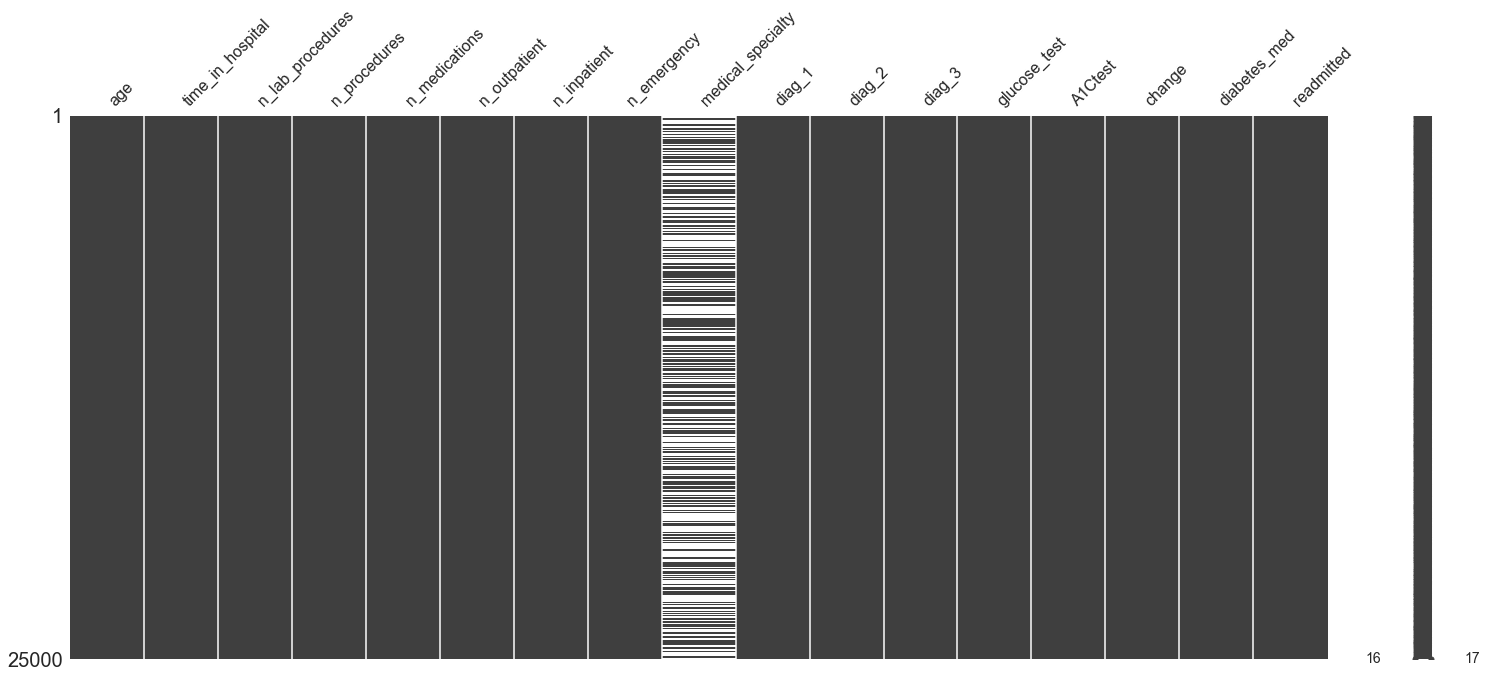

In [199]:
# Check for null values
df['medical_specialty'] = [np.nan if val == 'Missing' else val for val in list(df['medical_specialty'])]
msno.matrix(df)
plt.show()
df.drop('medical_specialty' , axis=1 , inplace=True , errors='ignore')
original_df = df.copy(deep=True)

In [200]:
# Process the yes or no columns
for col in df:
    if list(df[col].unique()) == ['yes' , 'no'] or list(df[col].unique()) == ['no' , 'yes']:
        df[col] = [1 if val == 'yes' else 0 for val in list(df[col])]

# Check the types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   age               25000 non-null  object
 1   time_in_hospital  25000 non-null  int64 
 2   n_lab_procedures  25000 non-null  int64 
 3   n_procedures      25000 non-null  int64 
 4   n_medications     25000 non-null  int64 
 5   n_outpatient      25000 non-null  int64 
 6   n_inpatient       25000 non-null  int64 
 7   n_emergency       25000 non-null  int64 
 8   diag_1            25000 non-null  object
 9   diag_2            25000 non-null  object
 10  diag_3            25000 non-null  object
 11  glucose_test      25000 non-null  object
 12  A1Ctest           25000 non-null  object
 13  change            25000 non-null  int64 
 14  diabetes_med      25000 non-null  int64 
 15  readmitted        25000 non-null  int64 
dtypes: int64(10), object(6)
memory usage: 3.1+ MB


## 1. What is the most common primary diagnosis by age group ?
The most common primary diagnosis by age group is circulatory for all categories.
We can also see that the age category with the highest percentage of circulatory first diagnosis is the 70-80 category.

In [201]:
df['age'] = [age.replace('[' , '').replace(')' , '') for age in list(df['age'])]

to_print = df[df['diag_1'] != 'Other'].groupby('age' , as_index=False)['diag_1'].apply(statistics.mode)
perc_ = []
for age in list(to_print['age']):
    perc = round(len(df[(df['age'] == age) & (df['diag_1'] == 'Circulatory')]) / len(df[df['age'] == age]),3) * 100
    perc_.append(perc)
    
to_print['percentage'] = perc_

print('     Mode diagnostic 1 :\n\n' , to_print)

     Mode diagnostic 1 :

       age       diag_1  percentage
0   40-50  Circulatory        19.9
1   50-60  Circulatory        28.2
2   60-70  Circulatory        33.2
3   70-80  Circulatory        35.0
4   80-90  Circulatory        32.8
5  90-100  Circulatory        30.4


## 2. Explore the effect of a diabetes diagnosis on readmission rates. 
It turns out that diabetes has a statistically significant role in the percentage of readmission. Indeed, between the group of people with diabetes and the group of people without diabetes, the percentage of readmission varies by more than 7 percent, as we can see in the figure below.<br/>
<br/>
___Technical part___ :<br/>
I used the two-proportion Z-test , which is a statistical hypothesis test used to determine whether two proportions are different from each other. 
To find out which patients have diabetes, I created a new variable for patients who had a first , second or third diabetes diagnosis, and/or who were taking medication for diabetes.

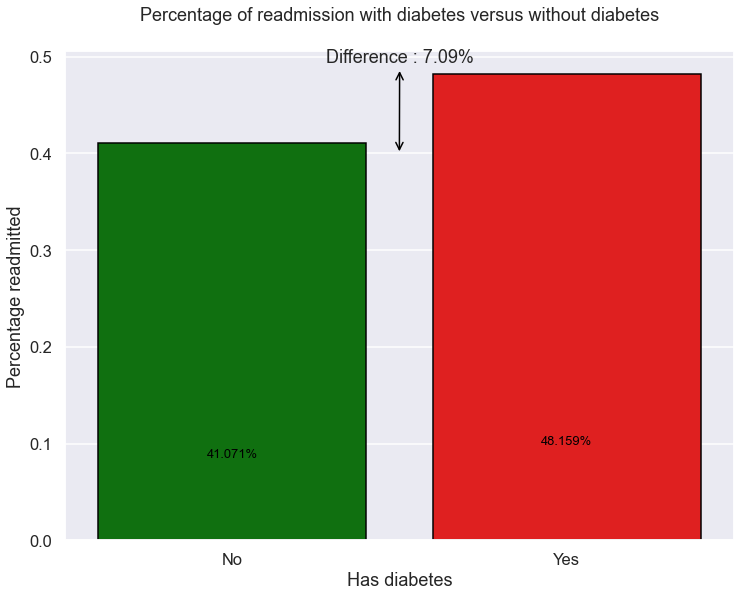


There is a proportional difference in the number of readmissions between people that have diabetes and people that don't , according to the Two-Proportion Z Test.


In [202]:
# Add the 'Diabete diagnostic' column
diabete_diag = []
for i in range(len(df)):
    if df.iloc[i]['diag_1'] == 'Diabetes' or df.iloc[i]['diag_2'] == 'Diabetes' or df.iloc[i]['diag_3'] == 'Diabetes' or df.iloc[i]['diabetes_med'] == 1:
        diabete_diag.append(1)
    else:
        diabete_diag.append(0)

df['diabete_diag'] = diabete_diag

# Check if there is enought observation for inference
assert (len(df[df['diabete_diag'] == 1]) > 100) & (len(df[df['diabete_diag'] == 0]) > 100)
to_plot = df.groupby('diabete_diag' , as_index=False)[['readmitted']].value_counts(normalize=True)
to_plot = to_plot[to_plot['readmitted'] == 1]
to_plot = to_plot.drop('readmitted' , axis=1)
to_plot.columns = ['Has diabetes' , 'Percentage readmitted']
diab_list = [str(round(float(to_plot[to_plot['Has diabetes'] == 0]['Percentage readmitted']) * 100 , 3))+'%' , str(round(float(to_plot[to_plot['Has diabetes'] == 1]['Percentage readmitted']) * 100 , 3))+'%']
diff_ = round((float(to_plot[to_plot['Has diabetes'] == 1]['Percentage readmitted']) - float(to_plot[to_plot['Has diabetes'] == 0]['Percentage readmitted'])) * 100 , 2)

# Function to add text in the middle of the bar
def autolabel_center(rects , ax , to_plot): 
    for i in range(len(rects)):
        height = rects[i].get_height()
        ax.text(rects[i].get_x() + rects[i].get_width() / 2, 0.2 * height,to_plot[i]\
             , ha='center', va='bottom', color='black' , fontsize=13)

# Visualize the percentage for the two categories (with and without diabetes)
sns.set_style('darkgrid')
with sns.plotting_context('talk'):
    plt.figure(figsize=(12,9))
    ax = sns.barplot(data=to_plot , x='Has diabetes' , y='Percentage readmitted' , palette=['green' , 'red'] , edgecolor='black')
    autolabel_center(ax.patches , ax , diab_list)
    plt.annotate(text= f'Difference : {diff_}%',  xy=(0.50,0.4) , xytext=(0.28,0.49), arrowprops=dict(arrowstyle='<->' , facecolor='black' , lw= 1.5 ,  color='black') ,verticalalignment='bottom')
    plt.xticks(ticks=[1 , 0] ,  labels=['Yes' , 'No'])
    plt.title('Percentage of readmission with diabetes versus without diabetes' , y=1.05)
    plt.show()

# Hypothesis testing
#print(df.groupby('diabete_diag')['readmitted'].value_counts())
alpha = 0.05
readmited = np.array([1656 , 10098]) # N success
nobs_ = np.array([2376 + 1656 , 10870 + 10098]) # Total by groups
z_score , p_val = proportions_ztest(count=readmited, nobs=nobs_)

if p_val < alpha:
    print('\nThere is a proportional difference in the number of readmissions between people that have diabetes and people that don\'t , according to the Two-Proportion Z Test.')
else:
    print('\nThere is no evidence that there is a proportional difference in the percentage of readmissions between people that have diabetes and people that don\'t , according to the Two-Proportion Z Test.')

## 3. On what groups of patients should the hospital focus their follow-up efforts to better monitor patients with a high probability of readmission?

Before starting the modeling part, it is always interesting to understand the variables of importance.<br/>
<br/>
___Technical part___ :<br/>
The 'target' variable is binary, so I used metrics accordingly to assess the relative importance of each variable. For the numeric variables (which are all discrete), I used the percentage change in means between patients who had been readmitted and those who had not , as well as Point-Biserial correlation coefficient with the Yeo-Johnson transformation applied to the data in order to respect the Point-Biserial correlation assumptions. For categorical variables, I used cramer's V test, which measures how closely two categorical fields are related.

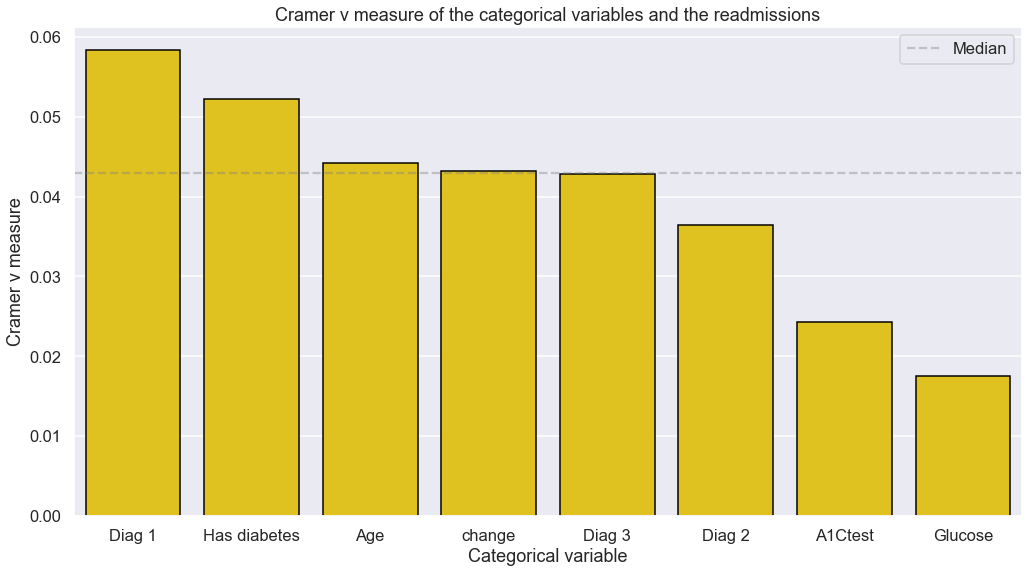

In [203]:
def cramer_v(dataset , with_degree_of_freedom=False):
    '''Compute the cramer v test for a numpy dataset.'''
    
    import pandas as pd
    if type(dataset) == pd.DataFrame: # To a numpy array
        dataset = dataset.values

    X2 = stats.chi2_contingency(dataset, correction=False)[0] # Finding Chi-squared test statistic for contingency tables (where the data are count from categorical variables) 
    N = np.sum(dataset) # Sample size. Because we work with categorical count data , all the number in the dataset are observations
    minimum_dimension = min(dataset.shape)-1 # Minimum of rows and columns (or degree of freedom)
        
    # Calculate Cramer's V
    result = np.sqrt((X2/N) / minimum_dimension)
        
    # Return the result
    if with_degree_of_freedom == False:
        return round(result , 5)
    else:
        return round(result , 5) , minimum_dimension


# Cramer v values
cramers = {}
cramers['Glucose'] = cramer_v(pd.crosstab(index=df['glucose_test'] , columns=df['readmitted'])) # For glucose
cramers['change'] = cramer_v(pd.crosstab(index=df['change'] , columns=df['readmitted'])) # For change in diabete medication
cramers['Age'] = cramer_v(pd.crosstab(index=df['age'] , columns=df['readmitted'])) # For age
cramers['Diag 1'] = cramer_v(pd.crosstab(index=df['diag_1'] , columns=df['readmitted'])) # For diag_1
cramers['Diag 2'] = cramer_v(pd.crosstab(index=df['diag_2'] , columns=df['readmitted'])) # For diag_2
cramers['Diag 3'] = cramer_v(pd.crosstab(index=df['diag_3'] , columns=df['readmitted'])) # For diag_2
cramers['Has diabetes'] = cramer_v(pd.crosstab(index=df['diabete_diag'] , columns=df['readmitted'])) # For diabetes_med
cramers['A1Ctest'] = cramer_v(pd.crosstab(index=df['A1Ctest'] , columns=df['readmitted'])) # For A1Ctest
cramers = pd.Series(cramers).sort_values(ascending=False)
median_ = np.median(cramers.values)

sns.set_style('darkgrid')
with sns.plotting_context('talk'):
    plt.figure(figsize=(17,9))
    sns.barplot(x=cramers.index , y=cramers.values , color='gold' , edgecolor='black')
    plt.axhline(median_ , color='grey' , alpha=0.4 , linestyle='--' , label='Median')
    plt.xlabel('Categorical variable')
    plt.ylabel('Cramer v measure')
    plt.title('Cramer v measure of the categorical variables and the readmissions')
    plt.legend()
    plt.show()

In this figure we can see that three variables stand out; The number of emergency room visits, the number of inpatient visits, and the number of outpatient visits. However, the average percentage change is not a perfect measure, it should be highlighted with another metric.

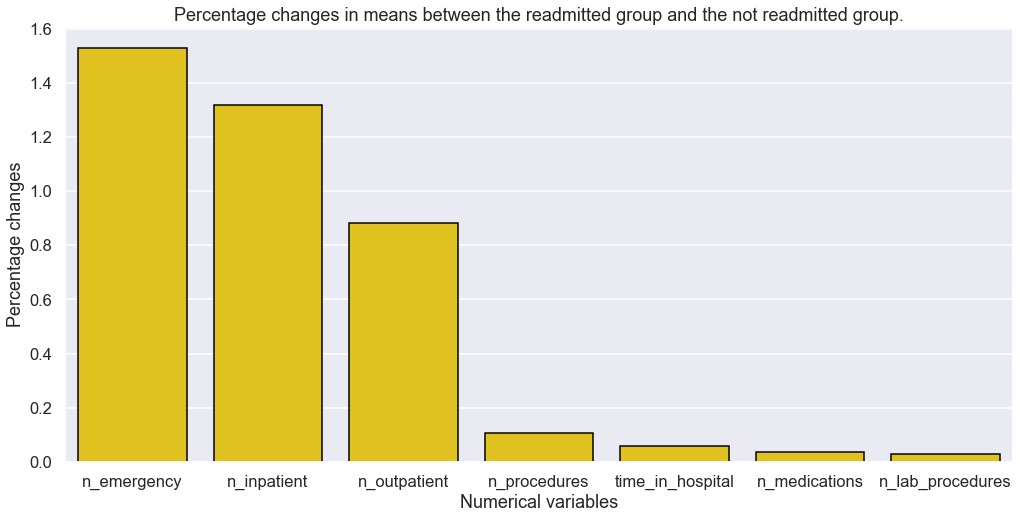

In [204]:
def compute_pct_change(col):
    '''Compute the differences in percentage for the readmitted and not readmitted group , to check the relative importance of each numerical variables'''
    t = df.groupby('readmitted' , as_index=False)[col].mean()
    return round(abs(float(t[t['readmitted'] == 0][col]) - float(t[t['readmitted'] == 1][col])) / float(t[t['readmitted'] == 0][col]) , 4)

# Test the pct changes to check the impact of each numerical variables
num_var = ['time_in_hospital',	'n_lab_procedures',	'n_procedures',	'n_medications',	'n_outpatient',	'n_inpatient',	'n_emergency']

diff_pct = {}
for col in num_var:
    diff_pct[col] = compute_pct_change(col)


to_plot = pd.Series(diff_pct).sort_values(ascending=False)

with sns.plotting_context('talk'):
    plt.figure(figsize=(17,8))
    sns.barplot(x=to_plot.index , y=to_plot.values , color='gold' , edgecolor='black')
    plt.ylabel('Percentage changes')
    plt.xlabel('Numerical variables')
    plt.title('Percentage changes in means between the readmitted group and the not readmitted group.')
    plt.show()

The calculation of the correlations shows rather weak correlations, but confirms the findings of the previous figure on the most important numerical variables.

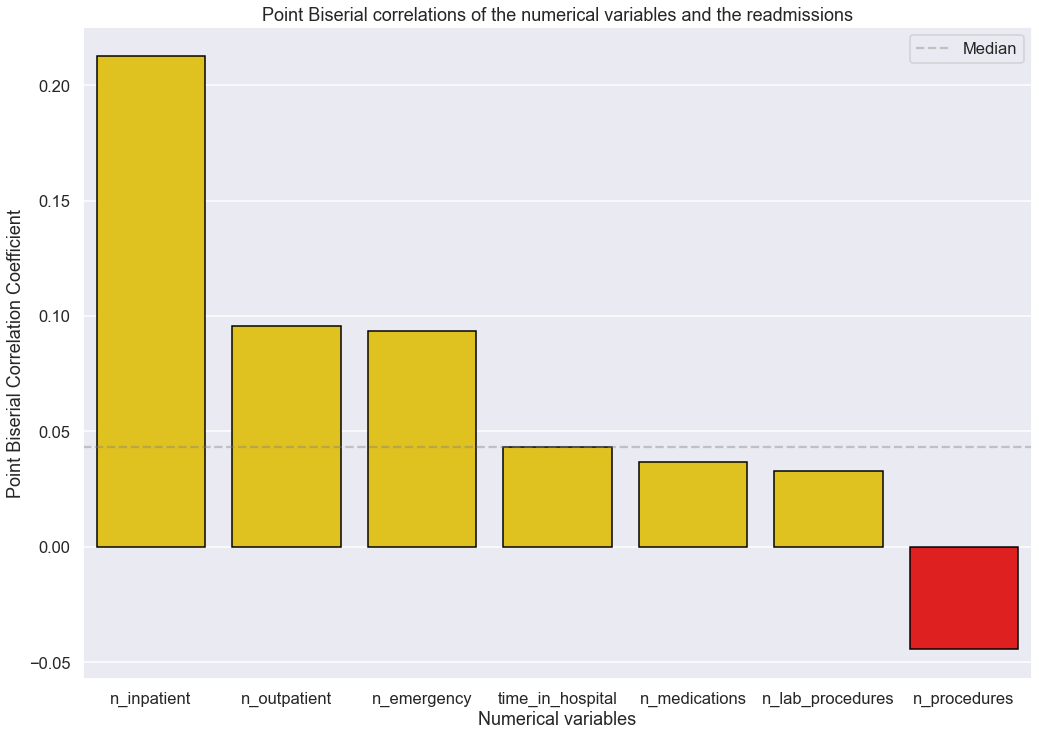

In [205]:
corr_ = {}
for col in num_var:
    trans_col = PowerTransformer().fit_transform(df[col].values.reshape(-1,1)) # Make the data more gaussian and continious
    cor = stats.pointbiserialr(x=df[col] , y=df['readmitted'])[0]
    corr_[col] = cor 

corr_ = pd.Series(corr_).sort_values(ascending=False)
median_ = np.median(corr_.values)
colors = ['gold' if val > 0 else 'red' for val in corr_.values]

with sns.plotting_context('talk'):
    plt.figure(figsize=(17,12))
    sns.barplot(x=corr_.index , y=corr_.values , palette=colors , edgecolor='black')
    plt.axhline(median_ , color='grey' , alpha=0.4 , linestyle='--' , label='Median')
    plt.xlabel('Numerical variables')
    plt.ylabel('point biserial correlation coefficient'.title())
    plt.title('Point Biserial correlations of the numerical variables and the readmissions')
    plt.legend()
    plt.show()

However, correlations do not capture the entire picture. Through the visualization that follows, we can see how our variables of importance interact with each other, and with the target variable. Here we can see , in the colored legend , the percentage of readmission for each combination of emergency visits / in + outpatient visits.

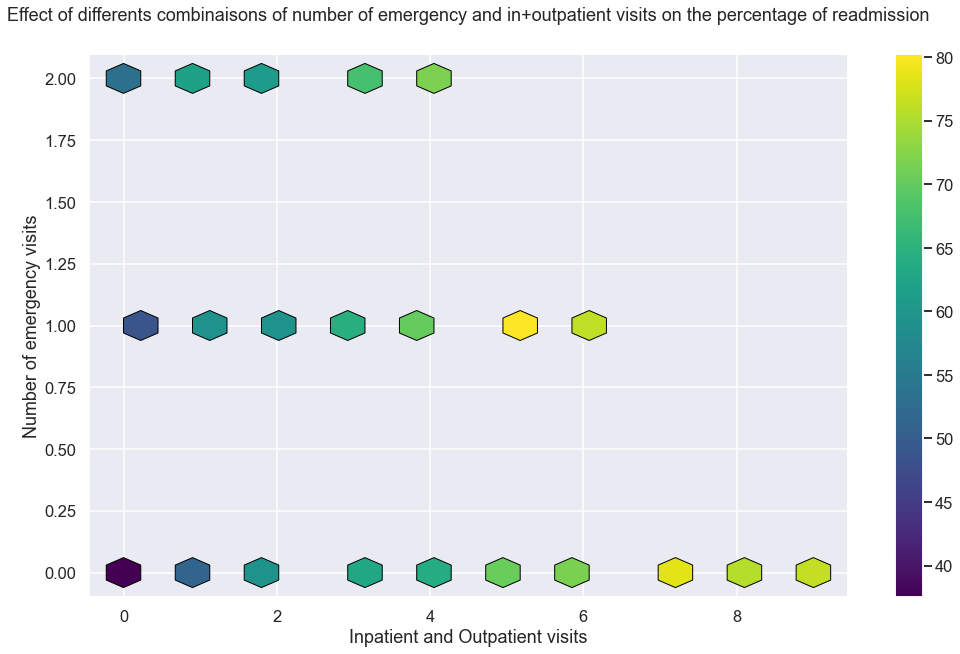

In [206]:
# Create a new variable with both in and outpatient visits
df['in_or_out'] = df['n_inpatient'] + df['n_outpatient']

# Get the lists of unique elements
to_it = df['in_or_out'].unique()
to_it_em = df['n_emergency'].unique()

# Create the combinaisons tuples
combinations = list(itertools.product(to_it, to_it_em))

# Iterate over the combinaisons to compute the percentages for each
int_or_out , ems_  , perc = [] , [] , []
for i_o , em in combinations:
    int_or_out.append(i_o)
    ems_.append(em)
    try:
        readm = len(df[(df['in_or_out'] == i_o) & (df['n_emergency'] == em) & (df['readmitted'] == 1)])
        total = len(df[(df['in_or_out'] == i_o) & (df['n_emergency'] == em)])
        if total > 30: # To be statisticaly significant
            perc.append((readm / total)*100)
        else:
            perc.append(np.nan)

    except ZeroDivisionError:
        perc.append(np.nan)

# Create the long format dataframe
to_plot = pd.DataFrame({'Inpatient and Outpatient visits' : int_or_out , 'Number of emergency visits' : ems_ , 'Percentage of readmission' : perc})

# Plot the hexagonal binning plot
with sns.plotting_context('talk'):
    to_plot.plot.hexbin(x='Inpatient and Outpatient visits',
                    y='Number of emergency visits',
                    C='Percentage of readmission',
                    reduce_C_function=np.mean,
                    gridsize=20,
                    cmap="viridis", edgecolors='black' , sharex=False , figsize=(17,10)
                    )
    

    plt.title('Effect of differents combinaisons of number of emergency and in+outpatient visits on the percentage of readmission' , y=1.05)

## Variables of importance
Regarding the numerical variables, the most important appear to be the number of inpatient visits , the number of emergency room visits and the number of outpatient visits in the year before a hospital stay. For the categorical variables, these are the first diagnosis, the fact of having diabetes or not, as well as the age category.<br/>
<br/>
In the visualization below, I explore the link between being readmitted and first diagnosis. We can see that patients whose first diagnosis is diabetes are more likely to be readmitted than others.

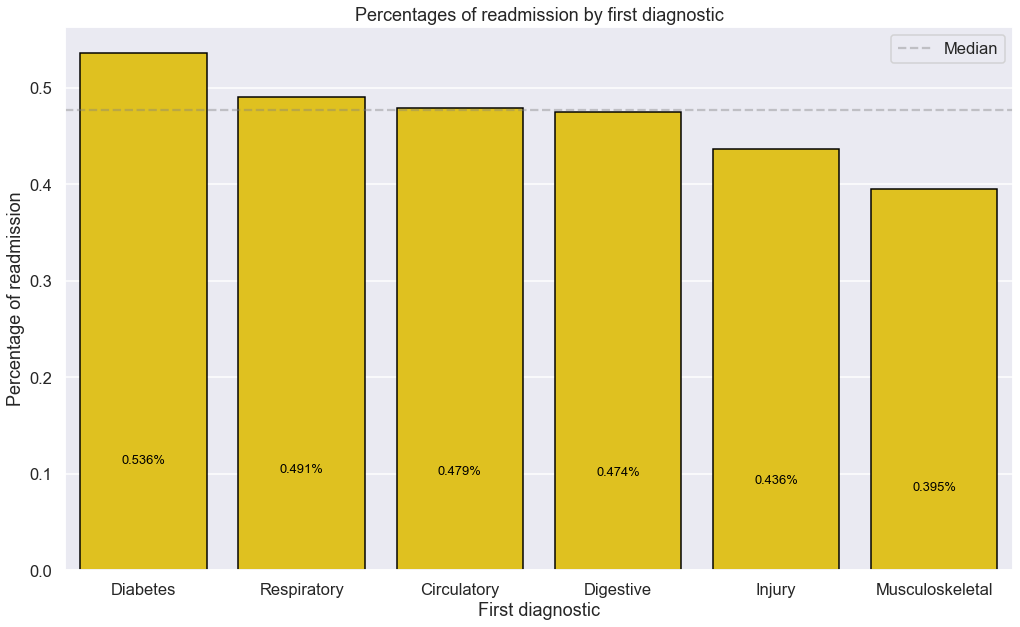

In [207]:
# What diagnosis has the highest percentage of readmitted people ?
grp = df[(df['diag_1'] != 'Other') & (df['diag_1'] != 'Missing')].groupby('diag_1' , as_index=False)['readmitted'].value_counts(normalize=True)
grp = grp[grp['readmitted'] == 1].drop('readmitted' , axis=1 , errors='ignore').sort_values(by='proportion' , ascending=False)
median_ = np.median(grp['proportion'])

with sns.plotting_context('talk'):
    plt.figure(figsize=(17,10))
    ax = sns.barplot(data=grp , x='diag_1' , y='proportion' , color='gold' , edgecolor='black')
    autolabel_center(ax.patches , ax , [f'{round(val,3)}%' for val in list(grp['proportion'])])
    plt.axhline(median_ , color='grey' , alpha=0.4 , linestyle='--' , label='Median')
    plt.xlabel('First diagnostic')
    plt.ylabel('Percentage of readmission')
    plt.legend()
    plt.title('Percentages of readmission by first diagnostic')
    plt.show()

An overwhelming portion of the patients in our dataset suffer from diabetes, as we can see in the figure below.

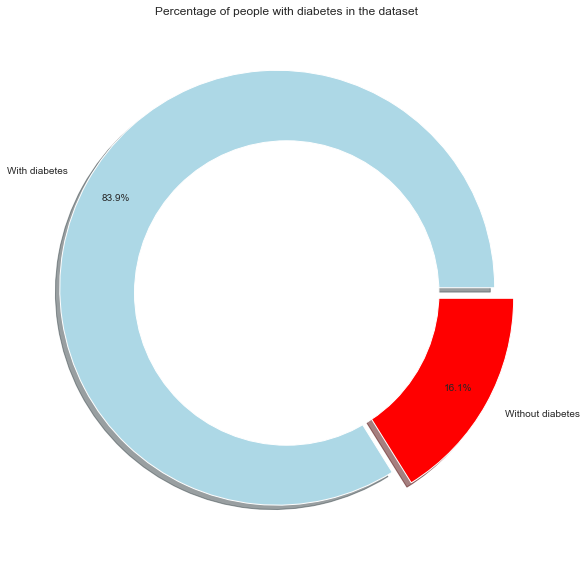

In [208]:
overall_diab = len(df[df['diabete_diag'] == 1]) / len(df)
plt.figure(figsize=(15,10))
explode = (0.05 , 0.05)
plt.pie([round(overall_diab * 100 , 3) , round((1 - overall_diab)*100 , 3)], labels=['With diabetes' , 'Without diabetes'], autopct='%1.1f%%', pctdistance=0.85, explode=explode , shadow=True , colors=['lightblue' , 'red'])
centre_circle = plt.Circle((0,0), 0.70, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
plt.title('Percentage of people with diabetes in the dataset')
plt.show()

The patients most at risk of being readmitted seem to be those in the 80-90 age group. Indeed, younger and older patients are less likely to be readmitted than those in the mentioned age group.

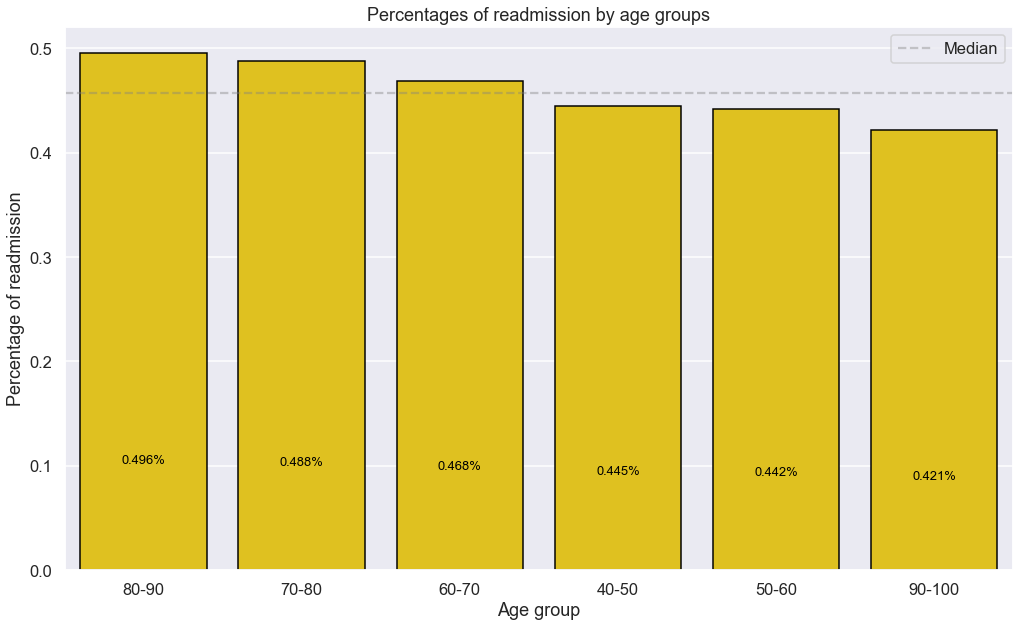

In [209]:
def plot_tree_map(variable : str , title_variable : str , df_ : pd.DataFrame , blues = True):
    
    
    counts = df_.groupby(variable, as_index=False).size()
    counts['prop'] = counts['size'] / df_.shape[0] * 100
    counts.sort_values(by='size', inplace=True, ascending=False)
    counts['rank'] = counts.prop.rank(method='min', ascending=False)

    # create a single root node
    counts['all'] = "All"

    if blues == True:
        color='Blues'
    else:
        color='Reds'

    fig = go.Figure()
    fig.add_trace(
        go.Treemap(
            labels = counts[variable],
            parents = counts['all'],
            values = counts.prop,
            customdata = counts[['size','rank']],
            root_color = 'lightgrey',
            marker_colorscale = color,
            hovertemplate = f'{title_variable}' +': %{label}'+'<br>Percentage: %{value:.2f}'+'<br>Count: %{customdata[0]:,}'+'<br>Rank: %{customdata[1]:.0f}</br>'+'<extra></extra>')
    )

    fig.update_layout(width = 600, height = 500,
                    uniformtext=dict(minsize=10, mode='hide'),
                    margin = dict(t=50, l=5, r=5, b=5),
                    title_text=f'{title_variable} repartition in the dataset')
    
    fig.show()


to_plot = df.groupby('age' , as_index=False)['readmitted'].value_counts(normalize=True)
to_plot = to_plot[to_plot['readmitted'] == 1].sort_values(ascending=False , by='proportion')
to_plot = to_plot.drop('readmitted' , axis=1 , errors='ignore')
to_plot['age'] = to_plot['age'].apply(lambda x : str(x).replace('[' , '').replace(')' , ''))
to_plot.columns = ['Age group' , 'Percentage of readmission']
median_ = np.median(to_plot['Percentage of readmission'])

with sns.plotting_context('talk'):
    plt.figure(figsize=(17,10))
    ax = sns.barplot(data=to_plot , x='Age group' , y='Percentage of readmission' , color='gold' , edgecolor='black')
    autolabel_center(ax.patches , ax , [f'{round(val,3)}%' for val in list(to_plot['Percentage of readmission'])])
    plt.axhline(median_ , color='grey' , alpha=0.4 , linestyle='--' , label='Median')
    plt.legend()
    plt.title('Percentages of readmission by age groups')
    plt.show()


In this figure we can see that the age group most at risk of being re-admitted represent 18 percent of our population. The majority category, with 27 percent of patients, are the 70-80 age group.

In [210]:
plot_tree_map('age' , 'Age' , df)

## Clustering patients
In order to determine the patients presenting the greatest chance of readmission, I used an unsupervised learning algorithm to separate the patients into several groups. <br/>
<br/>
___Technical part___:<br/>
I used the K-Prototypes algorithm, which is a mix between KMeans and KModes , in order to get the most out of variables of all types. To determine the number of clusters, I used the well-known elbow method, the results of which clearly indicate 5 clusters.

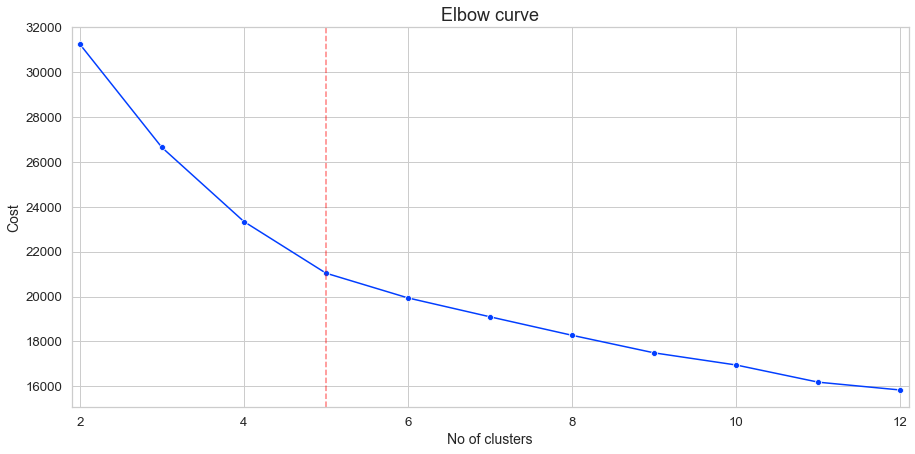

In [211]:
# Feature selection (drop unuseful variables and the target , to not influence the model)
original_df.drop(['Glucose' , 'A1Ctest' , 'Diag2' , 'glucose_test' , 'n_procedures' , 'change' , 'readmitted'] , axis=1 , errors='ignore' , inplace=True)

for col in original_df:
            if type(original_df.iloc[0][col]) == str:
                pass
            elif len(original_df[col].unique()) <= 3:
                original_df[col] = original_df[col].astype(object)
            else: 
                # Make the numerical variables more gaussian
                original_df[col] = PowerTransformer().fit_transform(original_df[col].values.reshape(-1, 1))


cat_index = [0 , 7 , 8 , 9 , 10]
sample_ = original_df.sample(5000) # To save time

# Function for plotting elbow curve
def plot_elbow_curve(start, end, data , n_clust : int):
                no_of_clusters = list(range(start, end+1))
                cost_values = []
                    
                for k in no_of_clusters:
                        test_model = KPrototypes(n_clusters=k, init='Huang', random_state=42)
                        test_model.fit_predict(data, categorical=cat_index)
                        cost_values.append(test_model.cost_)
                        
                sns.set_theme(style="whitegrid", palette="bright", font_scale=1.2)
                    
                plt.figure(figsize=(15, 7))
                ax = sns.lineplot(x=no_of_clusters, y=cost_values, marker="o", dashes=False)
                ax.set_title('Elbow curve', fontsize=18)
                ax.set_xlabel('No of clusters', fontsize=14)
                ax.set_ylabel('Cost', fontsize=14)
                ax.set(xlim=(start-0.1, end+0.1))
                plt.axvline(n_clust , linestyle='--' , color='red' , alpha=0.5)
                plt.plot();
                
# Plotting elbow curve
plot_elbow_curve(2,12,sample_ , n_clust=5)

# Add the clusters
clusters = KPrototypes(n_clusters=5, init='Huang', random_state=42).fit_predict(original_df, categorical=cat_index)
df['clusters'] = clusters 

## Results analysis
The algorithm found well-defined clusters. Here I would be specifically interested in the cluster with the highest readmission percentage ; the cluster number four.<br/>
<br/>
___Technical part___:
In order to represent the clusters at best, and to analyze the results of the algorithm, I used PCA (Principal Component Analysis) to be able to visualize my data in two dimensions, as well as snake plots for the numerical variables, which I normalized to be able to compare them.

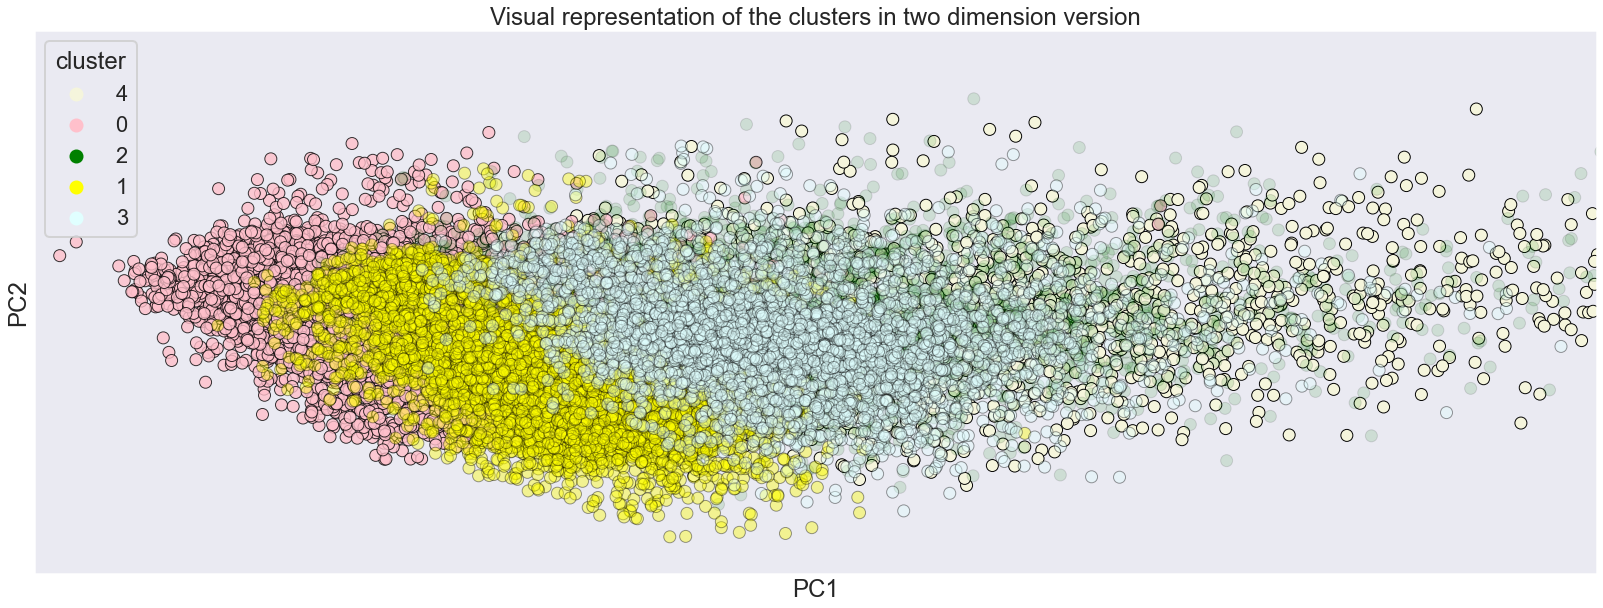

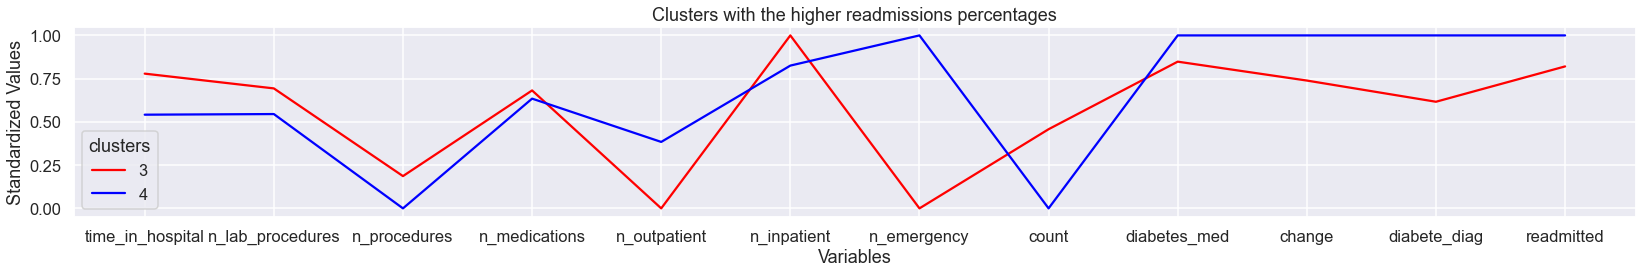

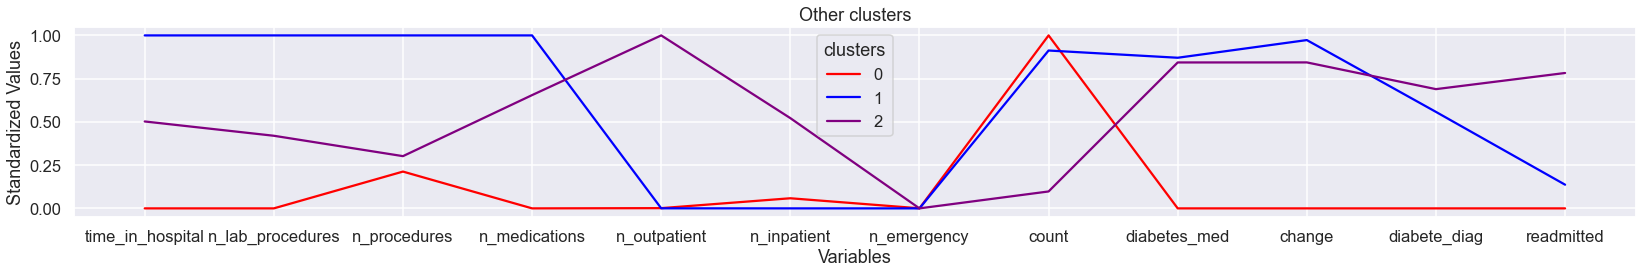

In [212]:
# Assess the results of the clustering
grouped = df.groupby('clusters' , as_index=False)[['time_in_hospital' , 'n_lab_procedures' , 'n_procedures' , 'n_medications' , 'n_outpatient' , 'n_inpatient' , 'n_emergency']].mean()

# Binaries
binary_cols = ['diabetes_med' , 'change' , 'diabete_diag' , 'readmitted']
to_plot_vals = pd.DataFrame()
for col in binary_cols:
    grp = df.groupby('clusters' , as_index=False)[col].value_counts(normalize=True)
    grp = grp[grp[col] == 1]
    to_plot_vals[col] = grp['proportion'].values

# Add the binaries and count columns
grouped['count'] = list(df.groupby('clusters')['diag_1'].count())
grouped[binary_cols] = to_plot_vals

# Long format
grouped = grouped.reset_index(drop=True)
scaled_grp = pd.DataFrame(MinMaxScaler().fit_transform(grouped.drop('clusters' , axis=1)) , columns=grouped.drop('clusters' , axis=1).columns)
scaled_grp['clusters'] = grouped['clusters']
long = scaled_grp.melt(id_vars=['clusters'],value_vars=list(grouped.drop('clusters' , axis=1).columns),var_name='Variables', value_name='Standardized Values')

# Display the clustering results using PCA
to_reduce = df.copy(deep=True)

for col in to_reduce:
    if to_reduce[col].dtypes == object:
        ohe = pd.get_dummies(to_reduce[col])
        to_reduce = to_reduce.drop(col , axis=1)
        to_reduce = pd.concat([to_reduce , ohe] , axis=1)    


pipeline = make_pipeline(StandardScaler() , PCA(n_components=2))
pca_data = pd.DataFrame(pipeline.fit_transform(to_reduce),columns=['PC1','PC2']) 
pca_data['cluster'] = df['clusters']

with sns.plotting_context('poster'):
    sns.set_style('dark')
    plt.figure(figsize=(28,10))
    sns.scatterplot(x="PC1",y="PC2",hue="cluster",data=pca_data[pca_data['cluster'] == 4] , palette=['beige'] , edgecolor='black' , alpha=1)
    sns.scatterplot(x="PC1",y="PC2",hue="cluster",data=pca_data[pca_data['cluster'] == 0] , palette=['pink'] , edgecolor='black' , alpha=0.8)
    sns.scatterplot(x="PC1",y="PC2",hue="cluster",data=pca_data[pca_data['cluster'] == 2] , palette=['green'] , edgecolor='black' , alpha=0.12)
    sns.scatterplot(x="PC1",y="PC2",hue="cluster",data=pca_data[pca_data['cluster'] == 1] , palette=['yellow'] , edgecolor='black' , alpha=0.4)
    sns.scatterplot(x="PC1",y="PC2",hue="cluster",data=pca_data[pca_data['cluster'] == 3] , palette=['lightcyan'] , edgecolor='black' , alpha=0.4)
    plt.ylim([-7 , 9])
    plt.xlim([-4 , 6.5])
    plt.xticks([])
    plt.yticks([])
    plt.title('Visual representation of the clusters in two dimension version')
    plt.show()
    
with sns.plotting_context('talk'):
    sns.set_style('darkgrid')
    plt.figure(figsize=(28,3.5))
    sns.lineplot(data=long[(long['clusters'] == 4) | (long['clusters'] == 3)] , x='Variables' , y='Standardized Values' , hue='clusters' , palette=['red', 'blue'])
    plt.title('Clusters with the higher readmissions percentages')
    plt.show()

with sns.plotting_context('talk'):
    sns.set_style('darkgrid')
    plt.figure(figsize=(28,3.5))
    sns.lineplot(data=long[(long['clusters'] == 1) | (long['clusters'] == 2) | (long['clusters'] == 0)] , x='Variables' , y='Standardized Values' , hue='clusters' ,  palette=['red', 'blue' , 'purple'])
    plt.title('Other clusters')
    plt.show()

Patients in the cluster of interest tend to be younger than the overall population of our dataset. They also have fewer procedures during the stay, more medications (maybe due to the greater percentage of people with diabetes), more inpatient, outpatient, and emergency room visits the year before the stay. <br/>
<br/> ___Technical part___: in order to couple visualizations to statistical inference tests, I used a non-parametric hypothesis test called Mann-Whitney U test (non-parametric version of the independent sample t-test) for each numerical variables,  which allows to compare two samples or groups and to test the statistical significance of a potential difference.

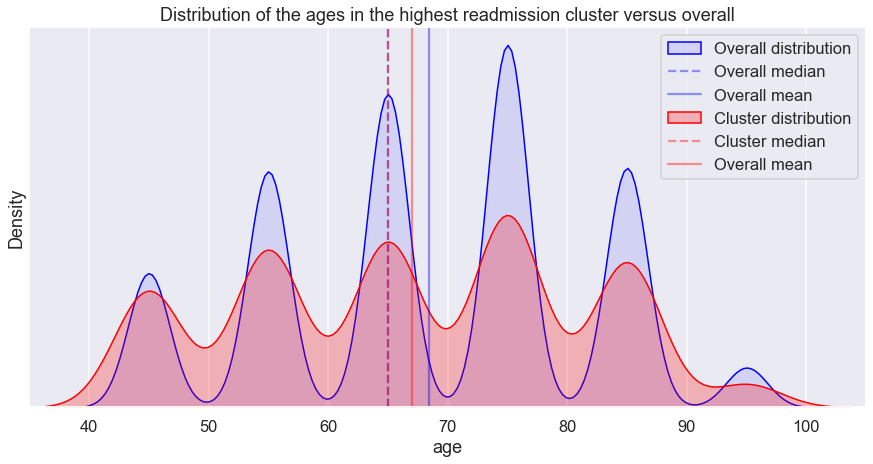

There is statistical evidences that there is differences between the two arrays , according to the Mann-Whitney U test.


In [213]:
df['age'] = [(str(age).replace('[' , '').replace(')' , '')) for age in df['age']]
df['age'] = [int(age.split('-')[0]) + 5  for age in df['age']]
to_compare = df[df['clusters'].isin([4])]

sns.set_style('darkgrid')
def plot_two_kde(data1 , data2 , title , xlim : list):
    with sns.plotting_context('talk'):
        plt.figure(figsize=(15,7))
        sns.kdeplot(data1 , shade=True , color='blue' , label='Overall distribution' , alpha=0.1)
        plt.axvline(data1.median() , color='blue' , linestyle='--' , label='Overall median' ,  alpha=0.4)
        plt.axvline(data1.mean() , color='blue' , label='Overall mean' ,  alpha=0.4)
        sns.kdeplot(data2 , shade=True , color='red' , label='Cluster distribution')
        plt.axvline(data2.median() , color='red' , linestyle='--' , label='Cluster median' ,  alpha=0.4)
        plt.axvline(data2.mean() , color='red'  , label='Overall mean' ,  alpha=0.4)
        plt.title(f'Distribution of the {title} in the highest readmission cluster versus overall')
        plt.xlim(xlim)
        plt.yticks([])
        plt.legend()
        plt.show()

def non_parametric_hypothesis_test_(data1 , data2):
    if stats.mannwhitneyu(data1 , data2)[1] < alpha:
        print('There is statistical evidences that there is differences between the two arrays , according to the Mann-Whitney U test.')
    else:
        print('There is no statistical evidences that there is differences between the two arrays  , according to the Mann-Whitney U test.')



plot_two_kde(data1=df['age'] , data2=to_compare['age'] , title='ages' , xlim=[35, 105])
non_parametric_hypothesis_test_(df['age'] , to_compare['age'])

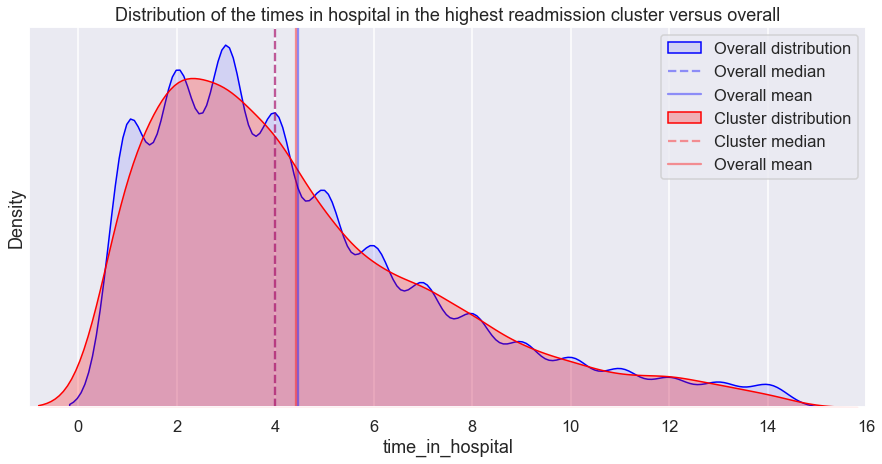

There is no statistical evidences that there is differences between the two arrays  , according to the Mann-Whitney U test.


In [214]:
plot_two_kde(data1=df['time_in_hospital'] , data2=to_compare['time_in_hospital'] , title='times in hospital' , xlim=[-1, 16])
non_parametric_hypothesis_test_(df['time_in_hospital'] , to_compare['time_in_hospital'])

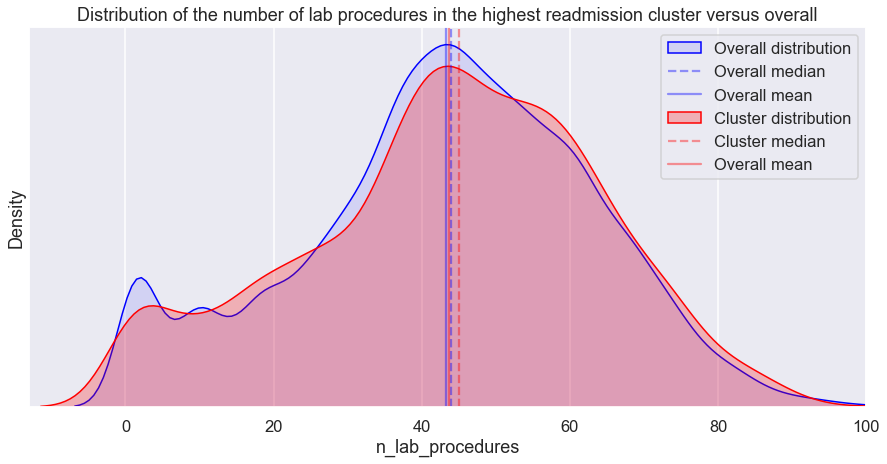

There is no statistical evidences that there is differences between the two arrays  , according to the Mann-Whitney U test.


In [215]:
plot_two_kde(data1=df['n_lab_procedures'] , data2=to_compare['n_lab_procedures'] , title='number of lab procedures' , xlim=[-13, 100])
non_parametric_hypothesis_test_(df['n_lab_procedures'] , to_compare['n_lab_procedures'])

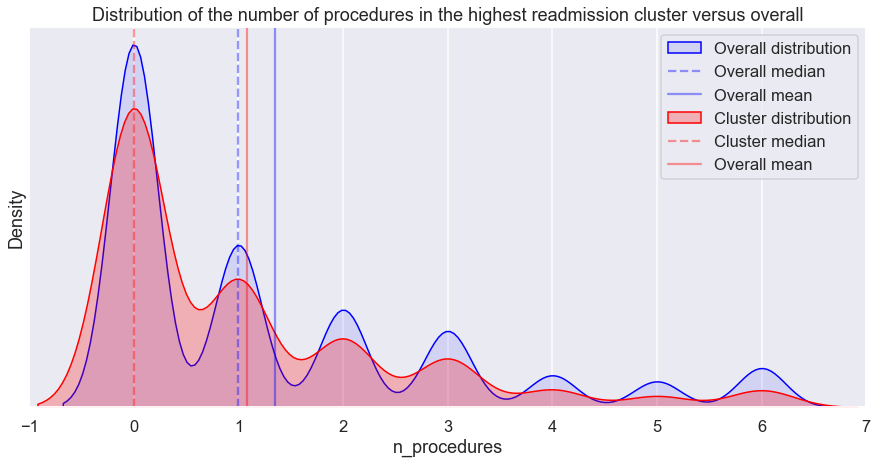

There is statistical evidences that there is differences between the two arrays , according to the Mann-Whitney U test.


In [216]:
plot_two_kde(data1=df['n_procedures'] , data2=to_compare['n_procedures'] , title='number of procedures' , xlim=[-1, 7])
non_parametric_hypothesis_test_(df['n_procedures'] , to_compare['n_procedures'])

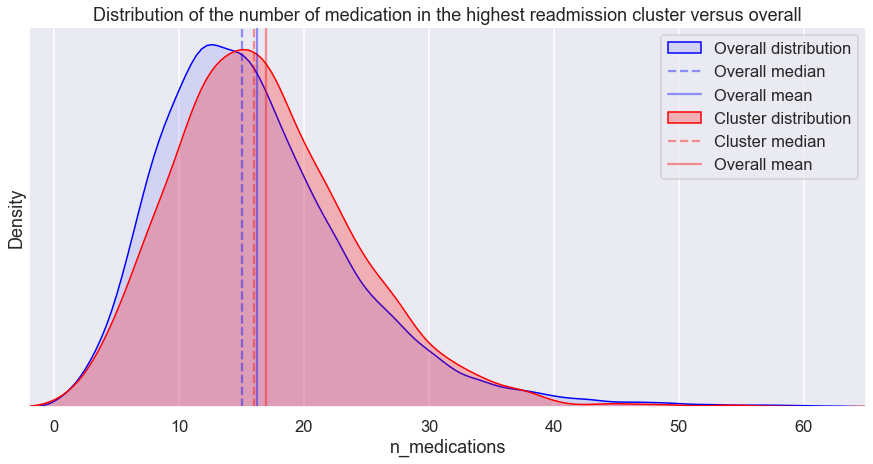

There is statistical evidences that there is differences between the two arrays , according to the Mann-Whitney U test.


In [217]:
plot_two_kde(data1=df['n_medications'] , data2=to_compare['n_medications'] , title='number of medication' , xlim=[-2, 65])
non_parametric_hypothesis_test_(df['n_medications'] , to_compare['n_medications'])

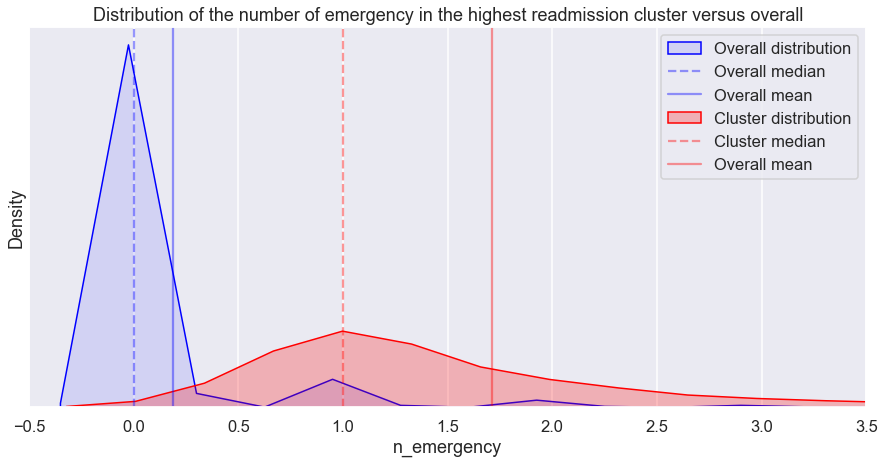

There is statistical evidences that there is differences between the two arrays , according to the Mann-Whitney U test.


In [218]:
plot_two_kde(data1=df['n_emergency'] , data2=to_compare['n_emergency'] , title='number of emergency' , xlim=[-0.5, 3.5])
non_parametric_hypothesis_test_(df['n_emergency'] , to_compare['n_emergency'])

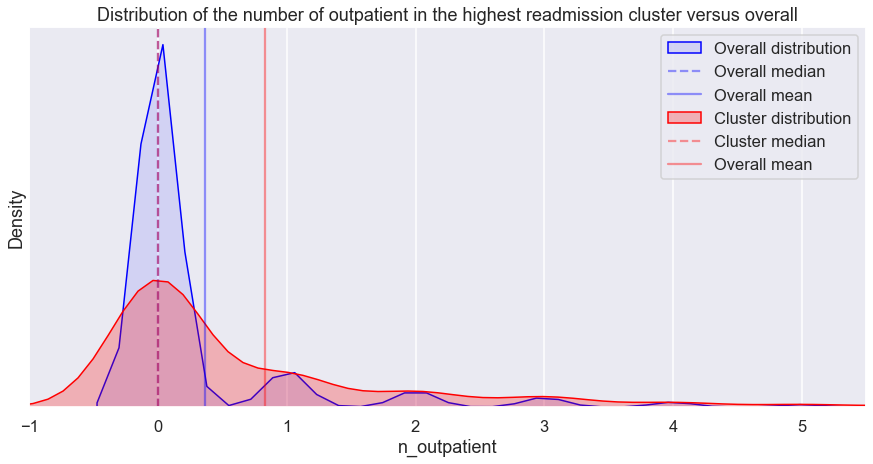

There is statistical evidences that there is differences between the two arrays , according to the Mann-Whitney U test.


In [219]:
plot_two_kde(data1=df['n_outpatient'] , data2=to_compare['n_outpatient'] , title='number of outpatient' , xlim=[-1, 5.5])
non_parametric_hypothesis_test_(df['n_outpatient'] , to_compare['n_outpatient'])

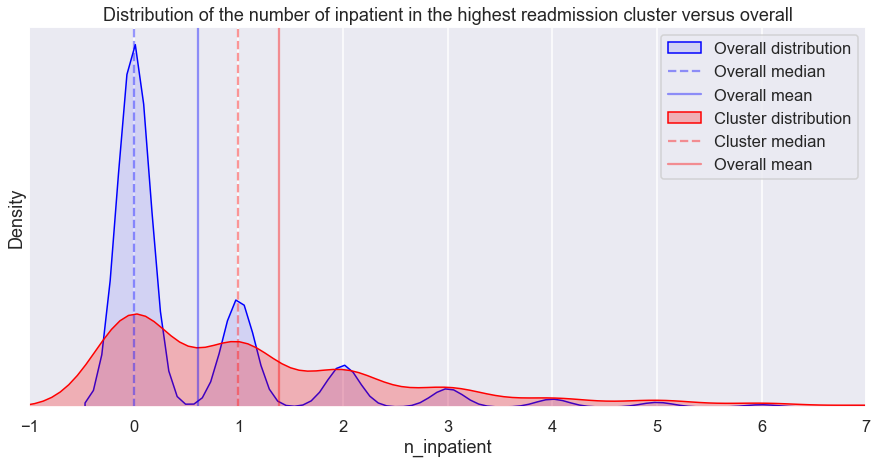

There is statistical evidences that there is differences between the two arrays , according to the Mann-Whitney U test.


In [220]:
plot_two_kde(data1=df['n_inpatient'] , data2=to_compare['n_inpatient'] , title='number of inpatient' , xlim=[-1, 7])
non_parametric_hypothesis_test_(df['n_inpatient'] , to_compare['n_inpatient'])

On these pie charts, we can observe a difference of 16 percent for the percentage of people readmitted between the cluster 4 and the overall dataset.

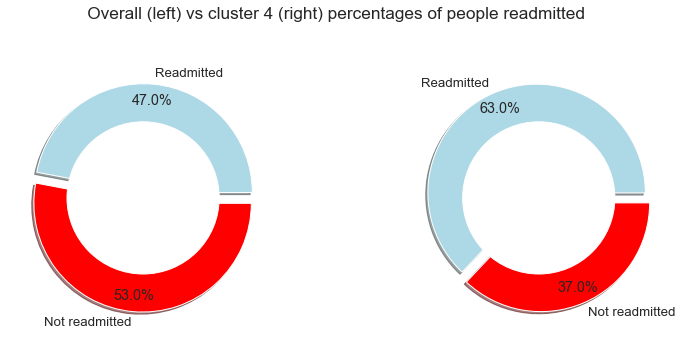

In [221]:
overall_diab = len(df[df['diabete_diag'] == 1]) / len(df)
cluster_diab = len(to_compare[to_compare['diabete_diag'] == 1]) / len(to_compare)

overall_read = len(df[df['readmitted'] == 1]) / len(df)
cluster_read = len(to_compare[to_compare['readmitted'] == 1]) / len(to_compare)

#first row, first column
plt.figure(figsize=(13,11))
ax1 = plt.subplot2grid((2,2),(0,0))
explode = (0.05 , 0.05)
plt.pie([round(overall_read * 100 , 3) , round((1 - overall_read)*100 , 3)], labels=['Readmitted' , 'Not readmitted'], autopct='%1.1f%%', pctdistance=0.85, explode=explode , shadow=True , colors=['lightblue' , 'red'])
centre_circle = plt.Circle((0,0), 0.70, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

#first row sec column
ax1 = plt.subplot2grid((2,2), (0, 1))
explode = (0.05 , 0.05)
plt.pie([round(cluster_read * 100 , 3) , round((1 - cluster_read)*100 , 3)], labels=['Readmitted' , 'Not readmitted'], autopct='%1.1f%%', pctdistance=0.85, explode=explode , shadow=True , colors=['lightblue' , 'red'])
centre_circle = plt.Circle((0,0), 0.70, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

fig.suptitle('   Overall (left) vs cluster 4 (right) percentages of people readmitted' , y=0.95)
plt.show()

Regarding the first diagnosis, the distribution is substantially the same, but we can observe that for the cluster of interest, diabetes as the first diagnosis is more common than in the global dataset.

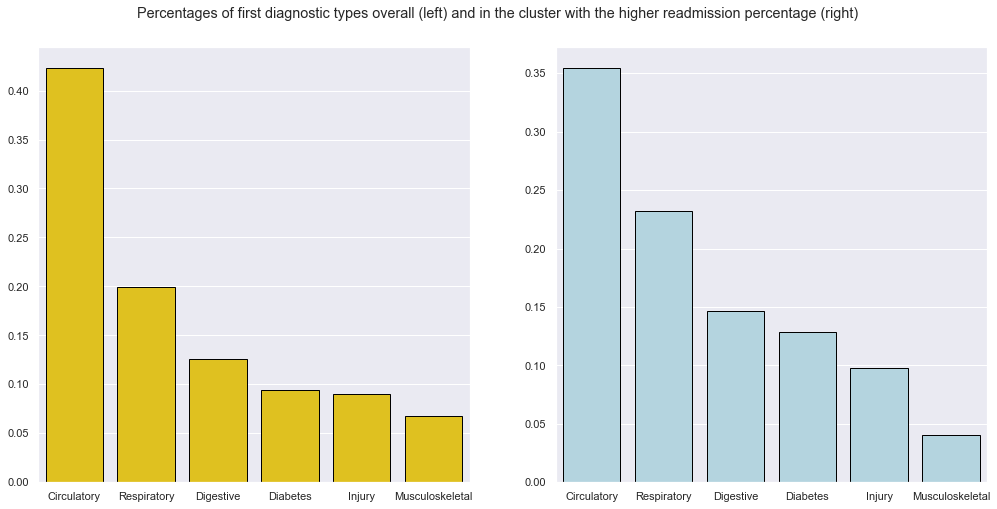

In [222]:
to_plot_df = df[df['diag_1'].isin(['Other' , 'Missing']) == False]['diag_1'].value_counts(normalize=True)
to_plot_clust = to_compare[to_compare['diag_1'].isin(['Other' , 'Missing']) == False]['diag_1'].value_counts(normalize=True)

with sns.plotting_context('notebook'):
    fig , (ax1 , ax2) = plt.subplots(1 , 2 , figsize=(17,8))
    sns.barplot(x=to_plot_df.index , y=to_plot_df.values , color='gold' , edgecolor='black' , ax=ax1)
    sns.barplot(x=to_plot_clust.index , y=to_plot_clust.values , color='lightblue' , edgecolor='black' , ax=ax2)
    fig.suptitle('Percentages of first diagnostic types overall (left) and in the cluster with the higher readmission percentage (right)' , y=0.95)
    plt.show()

We can also observe, on the pie charts that follow, a difference of 3.4 percent for the percentage of diabetics, as well as a difference of 5.1 percent for the percentage change in diabetes medications.

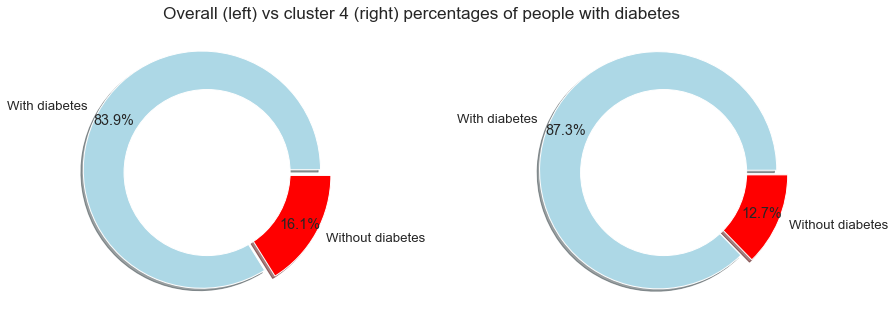

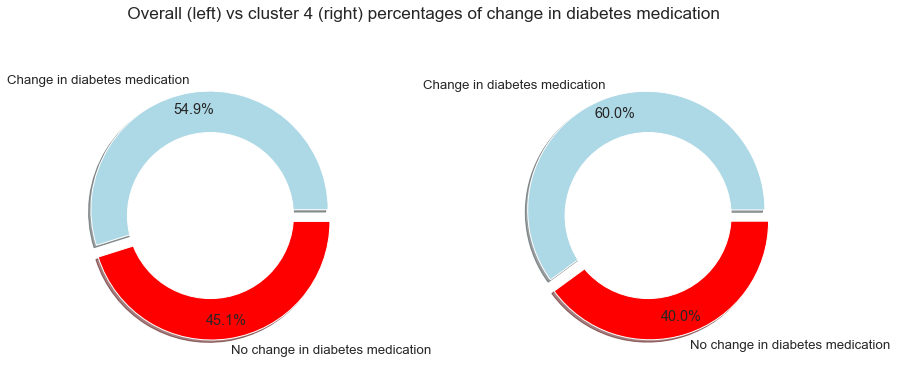

In [223]:
#first row, first column
plt.figure(figsize=(15,12))
ax1 = plt.subplot2grid((2,2),(0,0))
explode = (0.05 , 0.05)
plt.pie([round(overall_diab * 100 , 3) , round((1 - overall_diab)*100 , 3)], labels=['With diabetes' , 'Without diabetes'], autopct='%1.1f%%', pctdistance=0.85, explode=explode , shadow=True , colors=['lightblue' , 'red'])
centre_circle = plt.Circle((0,0), 0.70, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

#first row sec column
ax1 = plt.subplot2grid((2,2), (0, 1))
explode = (0.05 , 0.05)
plt.pie([round(cluster_diab * 100 , 3) , round((1 - cluster_diab)*100 , 3)], labels=['With diabetes' , 'Without diabetes'], autopct='%1.1f%%', pctdistance=0.85, explode=explode , shadow=True , colors=['lightblue' , 'red'])
centre_circle = plt.Circle((0,0), 0.70, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

fig.suptitle('Overall (left) vs cluster 4 (right) percentages of people with diabetes' , y=0.9)
plt.show()

overall_change_for_diabetes_med = round(df[df['diabete_diag'] == 1]['change'].sum() / len(df[df['diabete_diag'] == 1]) , 5) * 100
cluster_change_for_diabetes_med = round(to_compare[to_compare['diabete_diag'] == 1]['change'].sum() / len(to_compare[to_compare['diabete_diag'] == 1]) , 5) * 100

#first row, first column
plt.figure(figsize=(14.38,12))
ax1 = plt.subplot2grid((2,2),(0,0))
explode = (0.05 , 0.05)
plt.pie([overall_change_for_diabetes_med  , 100 - overall_change_for_diabetes_med], labels=['Change in diabetes medication' , 'No change in diabetes medication'], autopct='%1.1f%%', pctdistance=0.85, explode=explode , shadow=True , colors=['lightblue' , 'red'])
centre_circle = plt.Circle((0,0), 0.70, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

#first row sec column
ax1 = plt.subplot2grid((2,2),(0,1))
explode = (0.05 , 0.05)
plt.pie([cluster_change_for_diabetes_med  , 100 - cluster_change_for_diabetes_med], labels=['Change in diabetes medication' , 'No change in diabetes medication'], autopct='%1.1f%%', pctdistance=0.85, explode=explode , shadow=True , colors=['lightblue' , 'red'])
centre_circle = plt.Circle((0,0), 0.70, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

fig.suptitle('   Overall (left) vs cluster 4 (right) percentages of change in diabetes medication' , y=0.95)
plt.show()


# Statistical inference using a logistic regression
- Given the low predictive power of the logistic model on this particular problem, it would not be reliable to draw conclusions based on its coefficients.
- Since the accuracy score is only slightly better than chance, we can hypothesize that this problem is not linear.

In [224]:
from statsmodels.formula.api import glm 
import statsmodels.api as sm 
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
np.random.seed(12345)

# Preprocessing
try:
    df['age'] = [int(val[:2]) for val in df['age']]
except TypeError:
    pass 


# Split the data into training and testing , to assess goodness of fit for different set-ups
X = df.drop(['glucose_test' , 'A1Ctest' , 'diabetes_med'  , 'diag_2' , 'diag_3' , 'in_or_out' , 'n_lab_procedures'] , axis=1) # Also remove unimportant variables
y = df['readmitted']
X_train , X_test , y_train , y_test = train_test_split(X , y , test_size=0.2 , stratify=y) # SInce the data is quite balanced , no need to do sampling
X_train['readmitted'] = y_train

## Deal with multicollinearity 
I will use variance inflation factor with a threshold of 5 to detect problem variables for inference, in addition to the correlation matrix. I will also get rid of unimportant variables

           variables       VIF
0                age  7.847155
1   time_in_hospital  4.223862
2       n_procedures  1.930538
3      n_medications  7.496311
4       n_outpatient  1.155191
5        n_inpatient  1.802259
6        n_emergency  1.237367
7             change  2.345092
8         readmitted  2.004388
9       diabete_diag  6.516237
10          clusters  3.937176
11         Intercept       NaN 




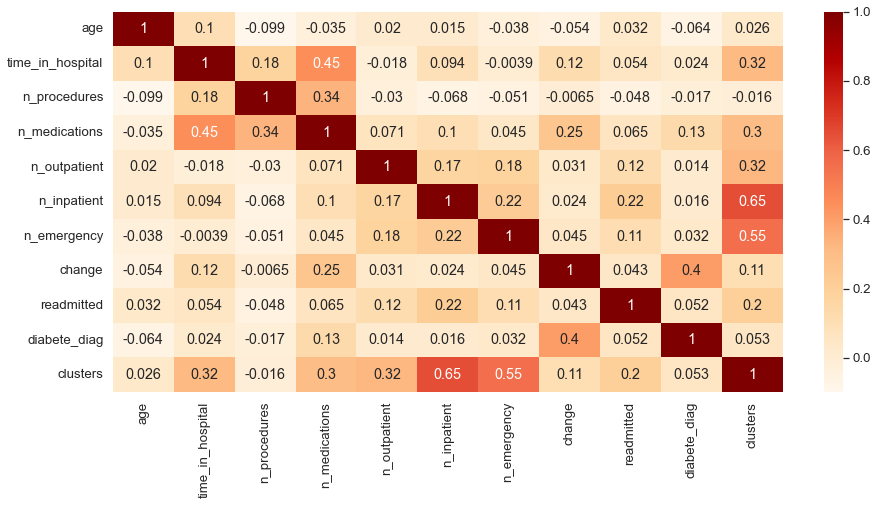

In [225]:
X_vif = X.copy()
X_vif = X_vif.drop('diag_1' , axis=1)
X_vif['Intercept'] = 0

vif = pd.DataFrame()
vif["variables"] = X_vif.columns
vif["VIF"] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]
print(vif , '\n\n')

plt.figure(figsize=(15,7))
sns.heatmap(X.corr(method='spearman') , annot=True , cmap='OrRd')
plt.show()

## Modeling
I created several models. A 'benchmark' model with few variables, and a more complete model in two versions (in order to avoid distorting the inference, due to the logical correlation between the variable diabetes_diag and change , which represents the change in medication for the diabetes)

In [226]:
# Benchmark model with only the most correlated variables 
formula_bench = 'readmitted ~ n_inpatient + n_emergency + diabete_diag + 0'

# First model : without diabete diagnostic but with change in medications
formula_diag= 'readmitted ~ age + time_in_hospital + n_procedures + n_medications + n_outpatient + n_inpatient + n_emergency + diabete_diag + diag_1 + 0'

# Second model : without change in diabetes medications but with diabetes diag. The performance should not change too much
formula_change = 'readmitted ~ age + time_in_hospital + n_procedures + n_medications + n_outpatient + n_inpatient + n_emergency + change + diag_1 + 0'

# Create the models
model_bench = glm(formula=formula_bench , data=X_train , family=sm.families.Binomial()).fit()
model_diag = glm(formula=formula_diag , data=X_train , family=sm.families.Binomial()).fit()
model_change = glm(formula=formula_change , data=X_train , family=sm.families.Binomial()).fit()

print(model_bench.summary() , '\n\n')
print('Accuracy score benchmark model : ' , accuracy_score(y_test , [1 if pred > 0.5 else 0 for pred in list(model_bench.predict(X_test))]))

                 Generalized Linear Model Regression Results                  
Dep. Variable:             readmitted   No. Observations:                20000
Model:                            GLM   Df Residuals:                    19997
Model Family:                Binomial   Df Model:                            2
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -13407.
Date:                Tue, 14 Mar 2023   Deviance:                       26813.
Time:                        11:06:06   Pearson chi2:                 2.16e+04
No. Iterations:                     5   Pseudo R-squ. (CS):            0.04118
Covariance Type:            nonrobust                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
n_inpatient      0.3620      0.015     23.543   

In [227]:
print(model_diag.summary() , '\n\n')
print('Accuracy score diabete diagnostic model : ' , accuracy_score(y_test , [1 if pred > 0.5 else 0 for pred in list(model_diag.predict(X_test))]))

                 Generalized Linear Model Regression Results                  
Dep. Variable:             readmitted   No. Observations:                20000
Model:                            GLM   Df Residuals:                    19984
Model Family:                Binomial   Df Model:                           15
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -13148.
Date:                Tue, 14 Mar 2023   Deviance:                       26297.
Time:                        11:06:06   Pearson chi2:                 2.15e+04
No. Iterations:                     5   Pseudo R-squ. (CS):            0.06563
Covariance Type:            nonrobust                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
diag_1[Circulatory]       

In [228]:
print(model_change.summary())
print('Accuracy score change in diabete medications model : ' , accuracy_score(y_test , [1 if pred > 0.5 else 0 for pred in list(model_change.predict(X_test))]))

                 Generalized Linear Model Regression Results                  
Dep. Variable:             readmitted   No. Observations:                20000
Model:                            GLM   Df Residuals:                    19984
Model Family:                Binomial   Df Model:                           15
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -13160.
Date:                Tue, 14 Mar 2023   Deviance:                       26320.
Time:                        11:06:06   Pearson chi2:                 2.15e+04
No. Iterations:                     5   Pseudo R-squ. (CS):            0.06457
Covariance Type:            nonrobust                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
diag_1[Circulatory]       

In [229]:
# Assessing the coefficients
to_it = model_diag.conf_int()
to_it[[0 , 1]] = to_it[[0 , 1]].apply(lambda x : np.exp(x))

print('----- Coefficient according to the logistic regression model : ----- \n\n\n')
for ind in to_it.index:
    vals = to_it.loc[ind].values
    print(f'For every one-unit increase in {ind} , the expected odds that the patient will be readmitted versus not readmitted is \n multiplied by a number between {vals[0]} and {vals[1]} , when all other variables are held constant.' , '\n\n')

----- Coefficient according to the logistic regression model : ----- 



For every one-unit increase in diag_1[Circulatory] , the expected odds that the patient will be readmitted versus not readmitted is 
 multiplied by a number between 0.2846392278281084 and 0.41867157896208074 , when all other variables are held constant. 


For every one-unit increase in diag_1[Diabetes] , the expected odds that the patient will be readmitted versus not readmitted is 
 multiplied by a number between 0.30670666947260855 and 0.46417317172479744 , when all other variables are held constant. 


For every one-unit increase in diag_1[Digestive] , the expected odds that the patient will be readmitted versus not readmitted is 
 multiplied by a number between 0.264974810664476 and 0.3956794592143985 , when all other variables are held constant. 


For every one-unit increase in diag_1[Injury] , the expected odds that the patient will be readmitted versus not readmitted is 
 multiplied by a number between 0.

## Further work from here

- It would be interesting to study the types of diabetes of the patients affected by this disease, in order to find new areas for improvement in the anticipation of their care. Also, adding specific data on each patient, such as weight, sex , and lifestyle could help refine the segmentation.

- Try different types of segmentations as well as other algorithms.

- Study the environment of the hospital (city, region, industries ...).

## Annex
- If you want to learn more about the clustering algorithm I used (K-Prototype) : https://antonsruberts.github.io/kproto-audience/

- If you want to learn more about the dimension reduction technique I used (Principal Component Analysis) : https://builtin.com/machine-learning/pca-in-python